# Naive MLP for MNIST with PyTorch

This notebook implements a simple MLP for MNIST digit classification using PyTorch. The architecture mirrors the reference implementation (784-256-128-10) from PyImageSearch's Adrian Rosebrock (Deep Learning 4 Computer Vision with Python Volume 1). Key difference is that this uses PyTorch, not the old TensorFlow + Keras kombo. Also, this implementation uses both two different ways to visualize training progress:

* Option A: Plot training history using matplotlib (stored in local variables)
* Option B: Log training progress to TensorBoard (stored in files in `runs/` folder)

This is nowhere near a state-of-the-art model, but serves as a good starting point for learning PyTorch basics.

## Imports

Note that it is a good idea to keep code organized even if you work with Notebook Cells. Instead of importing libraries all over the place, keep all imports in one cell at the top of the notebook.

In [44]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime

from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

## Teacher's setup

This Notebook has been initially run with a Macbook Pro with M2 Max chip. The code should support MPS, CUDA and CPU execution. If you have some other backend, adjust the code accordingly.

In [45]:
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

PyTorch version: 2.8.0
MPS available: True


### Configuration

In [46]:
# Configuration
USE_GPU = False  # Toggle this to False to use CPU instead

# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 128

# Device selection
if USE_GPU and torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device}")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print(f"Using device: {device}")

# Option B: TensorBoard setup for logging metrics to disk
device_name = str(device)
run_name = f"mnist_mlp_{device_name}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(f'runs/{run_name}')
print(f"TensorBoard logging to: runs/{run_name}")

# Option B: Log configuration information to TensorBoard
writer.add_text('config/device', device_name)
writer.add_text('config/hyperparameters', 
                f'LR: {LEARNING_RATE}, Batch: {BATCH_SIZE}, Epochs: {EPOCHS}')

Using device: cpu
TensorBoard logging to: runs/mnist_mlp_cpu_20251002_161916


### Load and Prepare Data

In [47]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load the training data
print("[INFO] accessing MNIST...")
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

[INFO] accessing MNIST...
Training samples: 60000
Test samples: 10000


In [55]:
# Verify class labels
# MNIST labels are digits 0-9, where the label directly corresponds to the digit
print("MNIST classes:", trainset.classes)
print("Class to index mapping:", trainset.class_to_idx)
print("\nVerification: Labels are digits 0-9 in order")

MNIST classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Class to index mapping: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}

Verification: Labels are digits 0-9 in order


### Define the Model

The model architecture is 784-256-128-10, matching the reference implementation.

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 784-256-128-10 architecture
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 784)
        # First layer with sigmoid activation
        x = torch.sigmoid(self.fc1(x))
        # Second layer with sigmoid activation
        x = torch.sigmoid(self.fc2(x))
        # Output layer with softmax (will use cross entropy loss which includes softmax)
        x = self.fc3(x)
        return x

# Initialize the model and move to device
model = MLP().to(device)
print(model)

# Option B: Log model architecture graph to TensorBoard
dummy_input = torch.randn(1, 1, 28, 28).to(device)
writer.add_graph(model, dummy_input)
print("Model graph logged to TensorBoard")

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
Model graph logged to TensorBoard


### Train the Model

In [49]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Option A: Initialize local history dictionary to store metrics in memory
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("[INFO] training network...")
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Option B: Log batch-level loss to TensorBoard every 50 batches
        if batch_idx % 50 == 0:
            global_step = epoch * len(trainloader) + batch_idx
            writer.add_scalar('Loss/train_batch', loss.item(), global_step)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate averages
    train_loss = train_loss / len(trainloader)
    train_acc = train_correct / train_total
    val_loss = val_loss / len(testloader)
    val_acc = val_correct / val_total
    
    # Option A: Append epoch metrics to local history lists
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Option B: Log comparative metrics (train vs val) to TensorBoard
    writer.add_scalars('Loss/train_vs_val', {
        'train': train_loss,
        'val': val_loss
    }, epoch)
    writer.add_scalars('Accuracy/train_vs_val', {
        'train': train_acc,
        'val': val_acc
    }, epoch)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("[INFO] training complete!")

# Option B: Log final hyperparameters with results for comparison across runs
writer.add_hparams(
    {'lr': LEARNING_RATE, 'batch_size': BATCH_SIZE, 'epochs': EPOCHS, 'device': device_name},
    {'hparam/final_train_acc': train_acc, 'hparam/final_val_acc': val_acc,
     'hparam/final_train_loss': train_loss, 'hparam/final_val_loss': val_loss}
)

# Option B: Close the TensorBoard writer to flush all remaining data
writer.close()
print("TensorBoard logs saved!")

[INFO] training network...
Epoch [10/100] - Train Loss: 0.7644, Train Acc: 0.8073, Val Loss: 0.7094, Val Acc: 0.8217
Epoch [20/100] - Train Loss: 0.4144, Train Acc: 0.8872, Val Loss: 0.3941, Val Acc: 0.8903
Epoch [30/100] - Train Loss: 0.3342, Train Acc: 0.9060, Val Loss: 0.3202, Val Acc: 0.9081
Epoch [40/100] - Train Loss: 0.2903, Train Acc: 0.9173, Val Loss: 0.2798, Val Acc: 0.9188
Epoch [50/100] - Train Loss: 0.2568, Train Acc: 0.9261, Val Loss: 0.2497, Val Acc: 0.9270
Epoch [60/100] - Train Loss: 0.2290, Train Acc: 0.9340, Val Loss: 0.2251, Val Acc: 0.9343
Epoch [70/100] - Train Loss: 0.2056, Train Acc: 0.9407, Val Loss: 0.2030, Val Acc: 0.9407
Epoch [80/100] - Train Loss: 0.1857, Train Acc: 0.9473, Val Loss: 0.1852, Val Acc: 0.9457
Epoch [90/100] - Train Loss: 0.1687, Train Acc: 0.9518, Val Loss: 0.1699, Val Acc: 0.9499
Epoch [100/100] - Train Loss: 0.1540, Train Acc: 0.9565, Val Loss: 0.1565, Val Acc: 0.9538
[INFO] training complete!
TensorBoard logs saved!


In [50]:
# Create models directory if it doesn't exist
Path('models').mkdir(parents=True, exist_ok=True)

# Save the model as state dict only. 
# We will use the runname to differentiate models.
model_path = f'models/{run_name}_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/mnist_mlp_cpu_20251002_161916_model.pth


### Evaluate the Model

In [51]:
from sklearn.metrics import classification_report
import numpy as np

print("[INFO] evaluating network...")
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print classification report
print(classification_report(all_labels, all_predictions,
                          target_names=[str(x) for x in range(10)]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.93      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.94      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



### Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix

# Define class names (MNIST digits 0-9)
# In MNIST, the class labels are the actual digit values (0-9)
# and they are already in the correct order
class_names = [str(i) for i in range(10)]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Option 1: Text-based confusion matrix (most compact)
print("Confusion Matrix (rows=true, cols=predicted):")
print("     ", "  ".join(f"{i:4}" for i in range(10)))
print("    " + "-" * 65)
for i, row in enumerate(cm):
    print(f"{i:2} | ", "  ".join(f"{val:4}" for val in row))

Confusion Matrix (rows=true, cols=predicted):
         0     1     2     3     4     5     6     7     8     9
    -----------------------------------------------------------------
 0 |   966     0     1     1     0     4     5     1     2     0
 1 |     0  1114     2     2     0     1     5     2     9     0
 2 |     9     2   975     6     5     0    10     9    14     2
 3 |     0     1    16   959     0    10     0    10    13     1
 4 |     2     1     3     0   941     0    10     1     2    22
 5 |     9     1     1    15     2   832    11     4    11     6
 6 |     9     3     3     0     8     8   922     0     5     0
 7 |     3     9    18     5     4     0     0   970     0    19
 8 |     5     1     4    15     7     7     8     8   917     2
 9 |     9     6     2     8    24     5     0    10     3   942


### Visualize Training History

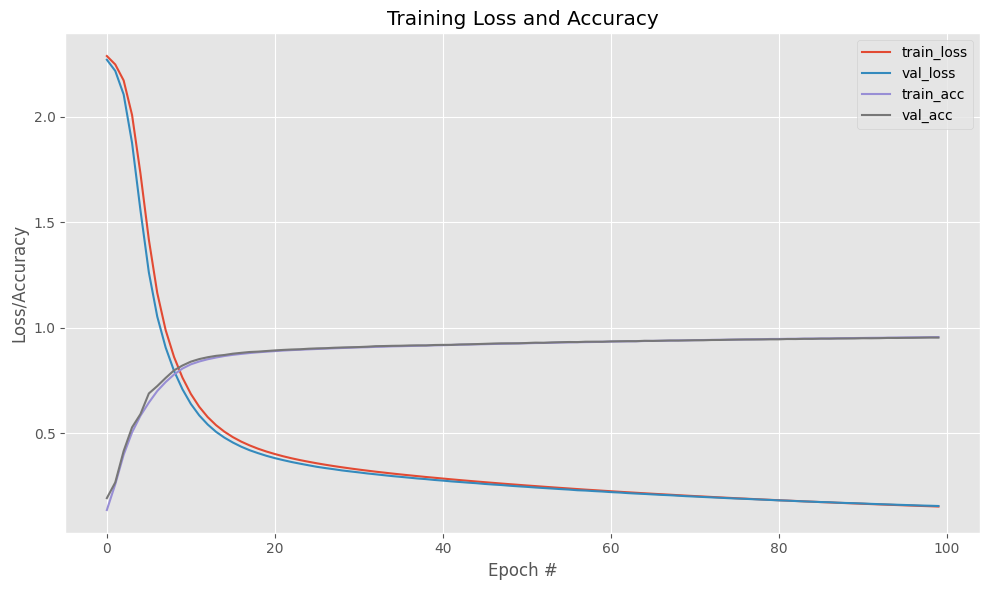

In [52]:
# Option A: Plot training history from local variables using matplotlib
plt.style.use("ggplot")
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, EPOCHS), history["train_loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history["train_acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### View TensorBoard

**Option B: View TensorBoard logs in your browser**

To view the training results in TensorBoard, run the following command in a terminal:

```bash
tensorboard --logdir=runs
```

Then open your browser to [http://localhost:6006](http://localhost:6006)

TensorBoard will show:
- **Scalars**: Training and validation loss/accuracy over time
- **Graphs**: Model architecture visualization
- **HParams**: Comparison of different runs with different hyperparameters
- **Text**: Configuration information